<div style="text-align: right"> Mark Hendricks </div>

<left>FINM 36700 - Portfolio Theory and Risk Management</left> 
<br>
<left>Fall 2022</left>

<h2><center> Homework 1 - The Harvard Management Company and Inflation-indexed Bonds </center></h2>

<center>Due on Monday, Oct 3</center>

<h3><span style="color:#00008B">Solution - Piyush Kontu</span></h3>

<h3><span style="color:#00008B">Email - pkontu@uchicago.edu</span></h3>

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import matplotlib.pyplot as plt

# Helper Functions

In [2]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Annualized Return').apply(lambda x: x*12)
    summary_stats['Annualized Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Annualized Sharpe Ratio'] = summary_stats['Annualized Return']/summary_stats['Annualized Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [3]:
def mvo_performance_stats(asset_returns,cov_matrix,port_weights, port_type,period):
    """ 
        Returns the Annualized Performance Stats for given asset returns, portfolio weights and covariance matrix
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
            port_weights = weights of the assets in the portfolio (1 x n) Vector
            port_type = Type of Portfolio | Eg - Tangency or Mean-Variance Portfolio
            period = Monthly frequency
    """
    
    ret = np.dot(port_weights,asset_returns)
    vol = np.sqrt(port_weights @ cov_matrix @ port_weights.T)*np.sqrt(period)
    sharpe = ret/vol

    stats = pd.DataFrame([[ret,vol,sharpe]],columns= ["Annualized Return","Annualized Volatility","Annualized Sharpe Ratio"], index = [port_type])
    return stats

In [4]:
def tangency_portfolio_rfr(asset_return,cov_matrix, cov_diagnolize = False):
    """ 
        Returns the tangency portfolio weights in a (1 x n) vector
        Inputs: 
            asset_return - return for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    if cov_diagnolize:
        asset_cov = np.diag(np.diag(cov_matrix))
    else:
        asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (asset_return)
    num =  inverted_cov @ asset_return
    return (1/den) * num

In [5]:
def mv_portfolio_rfr(asset_return,cov_matrix,target_ret,tangency_port):
    """ 
        Returns the Mean-Variance portfolio weights in a (1 x n) vector when a riskless assset is available
        Inputs: 
            asset_return - Excess return over the risk free rate for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
            target_ret = Target Return (Annualized)
            tangency_port = Tangency portfolio when a riskless assset is available
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    delta_den = (asset_return.T @ inverted_cov) @ (asset_return)
    delta_num = (one_vector @ inverted_cov) @ (asset_return)
    delta_tilde = (delta_num/delta_den) * target_ret
    return (delta_tilde * tangency_port)

In [6]:
def gmv_portfolio(asset_return,cov_matrix):
    """ 
        Returns the Global Minimum Variance portfolio weights in a (1 x n) vector
        Inputs: 
            asset_return - return for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
    """
    asset_cov = np.array(cov_matrix)
    inverted_cov= np.linalg.inv(asset_cov)
    one_vector = np.ones(len(cov_matrix.index))
    
    den = (one_vector @ inverted_cov) @ (one_vector)
    num =  inverted_cov @ one_vector
    return (1/den) * num

In [7]:
def mv_portfolio(asset_return,cov_matrix,target_ret,tangency_port):
    """ 
        Returns the Mean-Variance portfolio weights in a (1 x n) vector when no riskless assset is available
        Inputs: 
            asset_return - total return for each asset (n x 1) Vector
            cov_matrix = nxn covariance matrix for the assets
            target_ret = Target Return (Not-Annualized)
            tangency_port = Tangency portfolio
    """
    omega_tan = tangency_portfolio_rfr(asset_return.mean(),cov_matrix)
    omega_gmv = gmv_portfolio(asset_return,cov_matrix) 
    
    mu_tan = asset_return.mean() @ omega_tan
    mu_gmv = asset_return.mean() @ omega_gmv
    
    delta = (target_ret - mu_gmv)/(mu_tan - mu_gmv)
    mv_weights = delta * omega_tan + (1-delta)*omega_gmv
    return mv_weights

# Reading Data

In [8]:
descriptions = pd.read_excel(r'G:\My Drive\UChicago\Portfolio Theory TA Fall 2022\Week-1 2022-09-26\HW-1 Due 2022-10-03\multi_asset_etf_data.xlsx',sheet_name = 'descriptions',index_col = 'ticker').loc[:,['shortName']]
descriptions

,shortName
ticker,
SPY,SPDR S&P 500
EFA,iShares MSCI EAFE ETF
EEM,iShares MSCI Emerging Index Fun
PSP,Invesco Global Listed Private E
QAI,IQ Hedge MultiIQ Hedge Multi-St
HYG,iShares iBoxx $ High Yield Corp
DBC,Invesco DB Commodity Index Trac
IYR,iShares U.S. Real Estate ETF
IEF,iShares 7-10 Year Treasury Bond


In [9]:
total_ret = pd.read_excel(r'G:\My Drive\UChicago\Portfolio Theory TA Fall 2022\Week-1 2022-09-26\HW-1 Due 2022-10-03\multi_asset_etf_data.xlsx',sheet_name = 'total returns', index_col = 'Date')
rfr = total_ret.loc[:,['SHV']]
total_ret.drop('SHV',axis = 1, inplace = True)
total_ret.head()

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.008993,-0.001000,0.155582,0.115190,0.138460,-0.027452,0.296151,0.230202,0.022882,0.099346,-0.017952
2009-05-31,0.053672,0.162663,0.159400,0.131918,0.028555,-0.020773,0.022727,0.053892,0.027865,0.058454,0.019967
2009-06-30,0.005149,-0.026259,-0.022495,-0.014050,0.033516,-0.005572,-0.024863,0.045449,-0.003436,-0.000655,0.001982
2009-07-31,0.031284,0.018568,0.110146,0.100415,0.069191,0.008317,0.105799,0.143247,0.015326,0.074606,0.000879
2009-08-31,0.007628,-0.040365,-0.013136,0.045031,-0.016969,0.007635,0.131939,0.033413,-0.004151,0.036939,0.008413


In [10]:
excess_ret = pd.read_excel(r'G:\My Drive\UChicago\Portfolio Theory TA Fall 2022\Week-1 2022-09-26\HW-1 Due 2022-10-03\multi_asset_etf_data.xlsx',sheet_name = 'excess returns', index_col = 'Date')
excess_ret.head()

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2009-04-30,0.008439,-0.001554,0.155028,0.114636,0.137906,-0.028006,0.295597,0.229649,0.022329,0.098792,-0.018505
2009-05-31,0.054144,0.163134,0.159872,0.132390,0.029027,-0.020301,0.023199,0.054364,0.028337,0.058925,0.020438
2009-06-30,0.004549,-0.026858,-0.023094,-0.014649,0.032917,-0.006171,-0.025462,0.044850,-0.004035,-0.001254,0.001383
2009-07-31,0.031312,0.018595,0.110173,0.100442,0.069218,0.008344,0.105826,0.143274,0.015353,0.074633,0.000906
2009-08-31,0.007193,-0.040800,-0.013571,0.044595,-0.017404,0.007200,0.131503,0.032977,-0.004586,0.036504,0.007977


# 2 Mean-Variance Optimization

<i>This section is graded for a good-faith effort by your group. Submit your write-up- along with your supporting code. Don't just submit code or messy numbers; submit a coherent write-up based on your work.</i><br><br>

- The exhibit data that comes with the case is unnecessary-we use updated timeseries data.
- For our analysis, we use more current data found in multi asset etf data.xlsx. This data is posted in the GitHub repo for the course.
- The time-series data gives monthly returns for the 11 asset classes and a short-term Treasury-bill fund return, ("SHV",) which we consider as the risk-free rate.
- The data is provided in total returns, (in which case you should ignore the SHV column,) as well as excess returns, (where SHV has been subtracted from the other columns.)
- These are nominal returns-they are not adjusted for inflation, and in our calculations we are not making any adjustment for inflation.<br><br>

In the questions below, annualize the statistics you report.
- Annualize the mean of monthly returns with a scaling of 12.
- Annualize the volatility of monthly returns with a scaling of $\sqrt{12}$
- The Sharpe Ratio is the mean return divided by the volatility of returns. Accordingly, we can annualize the Sharpe Ratio with a scaling of $\sqrt{12}$
- Note that we are not scaling the raw timeseries data, just the statistics computed from it (mean, vol, Sharpe). <br><br>

We are going to analyze the problem in terms of total-not excess-returns.
- Thus, you will focus on the \Mean-Variance" section of the lecture notes, especially the formulas on slide 40.
- In using the "total returns" tab of the data, drop the column SHV. It is our proxy for the risk-free rate, which we are ignoring in our analysis of total returns.
- Thus, below, you are analyzing 11 risky assets-not SHV.

## 1. Summary Statistics

### 1.a) Calculate and display the mean and volatility of each asset's total return. (Recall we use volatility to refer to standard deviation.)

The analysis is based off the assumptions of annualized returns and volatility from historical data for each asset. 

In [11]:
tr_performance = performance_summary(total_ret)
tr_performance = tr_performance.merge(descriptions, left_index = True, right_index = True)
tr_performance.loc[:,['shortName','Annualized Return','Annualized Volatility','Annualized Sharpe Ratio']]

,shortName,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
BWX,SPDR Bloomberg International Tr,0.004653,0.078535,0.059248
DBC,Invesco DB Commodity Index Trac,0.038846,0.180186,0.215590
EEM,iShares MSCI Emerging Index Fun,0.072621,0.191787,0.378655
EFA,iShares MSCI EAFE ETF,0.081124,0.161885,0.501125
HYG,iShares iBoxx $ High Yield Corp,0.071588,0.089403,0.800730
IEF,iShares 7-10 Year Treasury Bond,0.025833,0.060077,0.429996
IYR,iShares U.S. Real Estate ETF,0.150128,0.184407,0.814113
PSP,Invesco Global Listed Private E,0.133272,0.221299,0.602227
QAI,IQ Hedge MultiIQ Hedge Multi-St,0.022862,0.048879,0.467723
SPY,SPDR S&P 500,0.150293,0.144811,1.037857


### 1.b) Which assets have the best and worst Sharpe ratios?

Amongst said portfolio, SPY index displays the best Sharpe ratio, while BWX (SPDR® Bloomberg International Treasury Bond ETF) performs the worst. Equity has consistently been one of the best performing assets for its return in the last 10 years (see BlackRock Return Map https://www.blackrock.com/corporate/insights/blackrock-investment-institute/interactive-charts/return-map). In addition, being a tracked ETF index, SPY diversifies the risk amongst different companies, reducing its volatility. Thus, the high return and low volatility resulted in the high Sharpe ratio for SPY. On the other hand, local currency debt has significantly low returns due to market movements these years.

In [12]:
max_sr = tr_performance.nlargest(1, 'Annualized Sharpe Ratio')
min_sr = tr_performance.nsmallest(1, 'Annualized Sharpe Ratio')
pd.concat([max_sr,min_sr]).loc[:,['shortName','Annualized Return','Annualized Volatility','Annualized Sharpe Ratio']]

,shortName,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
SPY,SPDR S&P 500,0.150293,0.144811,1.037857
BWX,SPDR Bloomberg International Tr,0.004653,0.078535,0.059248


## 2. Descriptive Analysis

### 2.a) Calculate the correlation matrix of the returns. Which pair has the highest correlation? And the lowest?

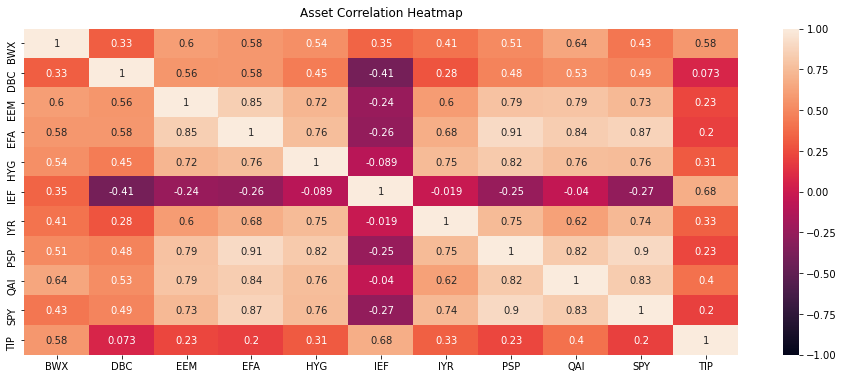

In [13]:
asset_corr = total_ret.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(asset_corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Asset Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


- <b>Max Correlation</b> - The highest correlation exhibits between EFA (Foreign Equity) and PSP (Private Equity). PE firms value their portfolio assets based on comparable analyses. Since asset values are benchmarked to traded companies, they are linked to each other. There is no better way to correlate two asset classes than to use one as the point of reference for the other. The reason behind less-than-perfect correlation is that PE fund managers value their portfolios quarterly rather than daily. (https://blogs.cfainstitute.org/investor/2020/12/16/myths-of-private-equity-performance-part-iii/) <br><br>

- <b>Min Correlation</b> - The lowest (most negative) correlation exhibits between DBC (Commodities) and IEF (Intermediate Treasury). Commodities, are a bet on unexpected inflation, and they have a low to negative correlation to other asset classes.


In [14]:
sorted_corr = asset_corr.unstack().sort_values().to_frame('Correlations')
sorted_corr = sorted_corr[sorted_corr['Correlations'] != 1]

max_corr = sorted_corr.nlargest(1, 'Correlations')
min_corr = sorted_corr.nsmallest(1, 'Correlations')
pd.concat([max_corr,min_corr])

,,Correlations
EFA,PSP,0.908746
DBC,IEF,-0.405431


### 2.b) How well have TIPS done in our sample? Have they outperformed domestic bonds? Foreign bonds?

In [61]:
TIPS_Sharpe = tr_performance[tr_performance.index.isin(['TIP'])]['Annualized Sharpe Ratio']
tr_performance = tr_performance.assign(Outperform_TIPS = lambda x : np.where(x['Annualized Sharpe Ratio'] >= float(TIPS_Sharpe),True,False))

tr_performance[tr_performance.index.isin(['IEF','BWX','HYG','TIP'])].loc[:,['shortName','Annualized Return','Annualized Volatility','Annualized Sharpe Ratio','Outperform_TIPS']]

,shortName,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Outperform_TIPS
BWX,SPDR Bloomberg International Tr,0.004653,0.078535,0.059248,False
HYG,iShares iBoxx $ High Yield Corp,0.071588,0.089403,0.800730,True
IEF,iShares 7-10 Year Treasury Bond,0.025833,0.060077,0.429996,False
TIP,iShares TIPS Bond ETF,0.034967,0.047833,0.731032,True


### 2.c) Based on the data, do TIPS seem to expand the investment opportunity set, implying that Harvard should consider them as a separate asset?

As observed from the correlation heatmap, TIPS’ monthly excess returns have the highest correlation with IEF (Domestic Treasury) and BWX (Foreign Treasury). As observed, TIPS also offers higher yields compared to IEF and BWX, in addition to low correlation to the rest of the assets. Thus, TIPS classifies as a new asset class in the market (HMC Case Study – Policy Portfolio, Policy 3). In addition, TIPS causes changes on current market assumptions (HMC Case Study – Policy Portfolio, Policy 2). With portfolio policy 2 and 3 both satisfied, TIPS should be added to the Harvard portfolio. 

In [16]:
asset_corr[asset_corr.index.isin(['TIP'])]

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
TIP,0.57696,0.073191,0.229728,0.200071,0.308617,0.68032,0.328398,0.228678,0.402777,0.203344,1.0


## 3. The MV Frontier

### 3.a) Compute and display the weights of the tangency portfolios: $w^{t}$.

In [17]:
mean_total_ret =  np.array(tr_performance['Annualized Return'])

tangency_port = tangency_portfolio_rfr(mean_total_ret,total_ret.cov())

TangencyPort_df = pd.DataFrame(tangency_port,columns= ["Tangency Portfolio Weight"],index=tr_performance.index)
TangencyPort_df = TangencyPort_df.merge(descriptions, left_index = True, right_index = True)
TangencyPort_df

,Tangency Portfolio Weight,shortName
BWX,-1.335168,SPDR Bloomberg International Tr
DBC,0.239151,Invesco DB Commodity Index Trac
EEM,0.339786,iShares MSCI Emerging Index Fun
EFA,-0.117068,iShares MSCI EAFE ETF
HYG,1.070489,iShares iBoxx $ High Yield Corp
IEF,2.457952,iShares 7-10 Year Treasury Bond
IYR,-0.307783,iShares U.S. Real Estate ETF
PSP,-0.513078,Invesco Global Listed Private E
QAI,-3.955222,IQ Hedge MultiIQ Hedge Multi-St
SPY,2.430623,SPDR S&P 500


### 3.b) Compute the mean, volatility, and Sharpe ratio for the tangency portfolio corresponding to $w^{t}$


We used scaling generated by the lagrangian multipliers, covariance matrix and mean excess return to generate the tangency portfolio weights. The return is given by  ω'µ and the variance of the portfolio given by ω'$∑^{-1}$ω, where ω is the weight vector of assets and ∑ is the covariance matrix of these assets. After getting both the excess mean return and the volatility, we can easily get the sharpe ratio of the tangency portfolio by dividing them.

In [18]:
tangency_port_stats = mvo_performance_stats(mean_total_ret,total_ret.cov(),tangency_port,'Tangency Portfolio',12)
tangency_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangency Portfolio,0.342822,0.175865,1.949342


## 4. The Allocation

### 4.a) Compute and display the weights of MV portfolios with target returns of $\mu^{p}$ = .015

To calculate the weights of the MV portfolios with monthly target returns of 0.015, we first calculate our delta which determines what percentage of our portfolio is allocated to the risky assets and the risk-free assets and scale the weights of the tangency portfolio accordingly.

In [19]:
target_ret = 0.015
mv_port= mv_portfolio(total_ret,total_ret.cov(),target_ret,tangency_port)

MVPort_df = pd.DataFrame(mv_port,columns= ["Mean-Variance Portfolio Weight"],index=tr_performance.index)
MVPort_df = MVPort_df.merge(descriptions, left_index = True, right_index = True)
MVPort_df

,Mean-Variance Portfolio Weight,shortName
BWX,-0.743896,SPDR Bloomberg International Tr
DBC,0.125074,Invesco DB Commodity Index Trac
EEM,0.140120,iShares MSCI Emerging Index Fun
EFA,-0.043110,iShares MSCI EAFE ETF
HYG,0.606047,iShares iBoxx $ High Yield Corp
IEF,1.303991,iShares 7-10 Year Treasury Bond
IYR,-0.163098,iShares U.S. Real Estate ETF
PSP,-0.316038,Invesco Global Listed Private E
QAI,-1.545644,IQ Hedge MultiIQ Hedge Multi-St
SPY,1.210202,SPDR S&P 500


### 4.b) What is the mean, volatility, and Sharpe ratio for $w^{p}$?

Here we notice that the Sharpe ratio is the same as the Sharpe ratio of our tangency portfolio which is to be expected. We are using delta to scale our tangency weights in order to achieve our goal of annualized portfolio return of 18% and therefore the mean returns and volatility are both decreasing linearly and therefore our Sharpe ratio remains the same. Graphically, the tangency portfolio, minimum variance portfolio (fully invested in riskless asset) and the mean variance portolfio all lie on the same line with the sharpe ratio of the portfolios as the slope

In [20]:
mv_port_stats = mvo_performance_stats(mean_total_ret,total_ret.cov(),mv_port,'Mean-Variance Portfolio',12)
mv_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio,0.18,0.093406,1.927061


### 4.c) Discuss the allocation. In which assets is the portfolio most long? And short?

- <b> Most Long Asset </b> - The portfolio is most long in IEF (Intermediate Treasury). This is due to its low correlation with other asset classes, in addition to its relatively higher returns. <br><br>

- <b> Most Short Asset </b> - The portfolio is shortest in QAI (Absolute Return IQ Multi-Strat). This is due to its very high correlation with other asset classes in addition to its relatively lower returns.



In [21]:
MVPort_df[MVPort_df['Mean-Variance Portfolio Weight'] == MVPort_df['Mean-Variance Portfolio Weight'].max()].head(1)

,Mean-Variance Portfolio Weight,shortName
IEF,1.303991,iShares 7-10 Year Treasury Bond


In [22]:
MVPort_df[MVPort_df['Mean-Variance Portfolio Weight'] == MVPort_df['Mean-Variance Portfolio Weight'].min()].head(1)

,Mean-Variance Portfolio Weight,shortName
QAI,-1.545644,IQ Hedge MultiIQ Hedge Multi-St


### 4.d) Does this line up with which assets have the strongest Sharpe ratios?

No, the allocation in the MV Portfolio do not line up with assets classes having the highest/lowest Sharpe Ratios. The optimization process to minimize the variance for a given return, prioritizes the penalization of high correlations and covariances. Whilst the sharpe ratio is an indirect factor, it can be deduced that the Sharpe ratio is not the main consideration in the optimization. This is evident from the fact that similar to QAI, EEM (iShares Emerging Markets) had higher correlations with other asset classes but given it had higher returns and lower vol compared to QAI, the portfolio was not most short in it.

### Not Required - For Illustration

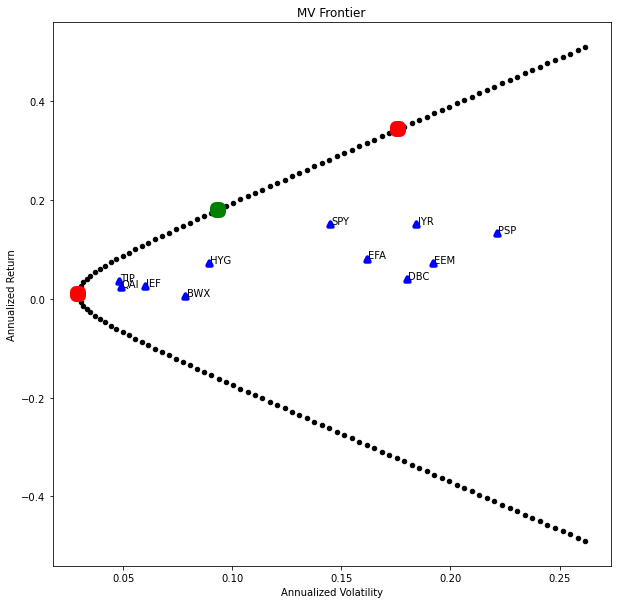

In [23]:
omega_tan= pd.DataFrame(tangency_portfolio_rfr(total_ret.mean(),total_ret.cov()), index=total_ret.columns)
omega_gmv= pd.DataFrame(gmv_portfolio(total_ret,total_ret.cov()), index=total_ret.columns)

omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-1.5,1.5,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = total_ret @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=total_ret.index)
rets_special['tan'] = total_ret @ omega_tan.values
rets_special['gmv'] = total_ret @ omega_gmv.values

mv_assets = pd.concat([total_ret.mean() * 12,total_ret.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=4)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)
mv_port_stats.plot.scatter(x = 'Annualized Volatility',y='Annualized Return',ax=ax, c='g', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

# 5. Simple Portfolios

### 5.a) Calculate the performance of the equally-weighted portfolio over the sample. Rescale the entire weighting vector to have target mean $\mu^{p}$ = .015. Report its mean, volatility, and Sharpe ratio.

Initially we get each weight by dividing 1 by the number of asssets (11 in this case). Then we multiply weight vector with mean return vector to get returns for this equally weighted portfolio. Let’s name it $r_1$. The weight vector has to be rescaled by multiplying by a factor of (Target Return/ $r_1$). 

After rescaling to target return the weights will not sum to 1, though the weights will still be equal. We expect higher vol of a portfolio for a given return thus a lower Sharpe ratio. As we are not considering variances and covariances. 

In [24]:
EqlWt = np.array(len(asset_corr.index) * [1/len(asset_corr.index)])
eql_rescale_factor = target_ret*12/(EqlWt.T @ mean_total_ret)

eql_wt_port_stats = mvo_performance_stats(mean_total_ret,total_ret.cov(),(EqlWt * eql_rescale_factor),'Equal Weight Portfolio',12)
eql_wt_port_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Equal Weight Portfolio,0.18,0.251661,0.715248


### 5.b) Calculate the performance of the "risk-parity" portfolio over the sample. Risk-parity is a term used in a variety of ways, but here we have in mind setting the weight of the portfolio to be proportional to the inverse of its full-sample volatility estimate.
### <center> $w^{i} = \frac{1}{\sigma_{i}} $ </center>
### This will give the weight vector, w, but you will need to rescale it to have a target mean of $\mu^{p}$ = .015.

Initially we get each weight by 1/ asset volatility. Then we multiply weight vector with mean return vector to get returns. Let’s name it $r_1$. The weight vector has to be rescaled by multiplying by a factor of (Target Return/ $r_1$). We expect higher volatility	of a portfolio for a given return compared to an MV Portfolio, thus a lower Sharpe ratio as we are not taking care of covariances.

In [25]:
risk_par_wt = np.array(1/tr_performance['Annualized Volatility'])
rp_rescale_factor = target_ret*12/ (risk_par_wt.T @ mean_total_ret)

risk_parity_stats = mvo_performance_stats(mean_total_ret,total_ret.cov(),(risk_par_wt * rp_rescale_factor),'Risk Parity Portfolio',12)
risk_parity_stats

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Risk Parity Portfolio,0.18,0.235607,0.763983


### 5.c) How does these compare to the MV portfolio from problem 2.4?

The MV Portfolio has lower vol compared to Risk Parity and Equal Weight as the MV Portfolio has diversification benefits which reduces the volatiliy for a target return. 

In [26]:
comparison = pd.concat([mv_port_stats,eql_wt_port_stats,risk_parity_stats,tangency_port_stats])
comparison

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio,0.180000,0.093406,1.927061
Equal Weight Portfolio,0.180000,0.251661,0.715248
Risk Parity Portfolio,0.180000,0.235607,0.763983
Tangency Portfolio,0.342822,0.175865,1.949342


## 6. Dropping TIPS

### Assess how much the Sharpe Ratio goes down if we drop TIPS from the investment set, (and just have a 10-asset problem.) See how much it decreases the performance statistics in 2.4.

In [27]:
total_ret_xTIP = total_ret.drop('TIP', axis =1 )
tr_xTIP_performance = performance_summary(total_ret_xTIP)

tangency_port_xTIP = tangency_portfolio_rfr(np.array(tr_xTIP_performance['Annualized Return']),total_ret_xTIP.cov())
tangency_xTIP_stats = mvo_performance_stats(np.array(tr_xTIP_performance['Annualized Return']),total_ret_xTIP.cov(),tangency_port_xTIP,'Tangency Portfolio ex-TIPS',12)
tangency_xTIP_stats

mv_port_xTIP= mv_portfolio(total_ret_xTIP,total_ret_xTIP.cov(),target_ret,tangency_port_xTIP)
mv_xTIP_stats = mvo_performance_stats(np.array(tr_xTIP_performance['Annualized Return']),total_ret_xTIP.cov(),mv_port_xTIP,'Mean-Variance Portfolio ex-TIPS',12)

pd.concat([tangency_port_stats,tangency_xTIP_stats,mv_port_stats,mv_xTIP_stats])

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Tangency Portfolio,0.342822,0.175865,1.949342
Tangency Portfolio ex-TIPS,0.369922,0.190779,1.939010
Mean-Variance Portfolio,0.180000,0.093406,1.927061
Mean-Variance Portfolio ex-TIPS,0.180000,0.094089,1.913092


## 7. Out of Sample Performance

### Let's divide the sample to both compute a portfolio and then check its performance out of sample.

### 7.a) Using only data through the end of 2021, compute $w^{p}$ for $\mu^{p}$ = .015, allocating to all 11 assets.

We used scaling generated by the lagrangian multipliers, covariance matrix and mean excess return for data only through end of 2021 to generate the tangency portfolio weights. The same data was then used to compute the delta which determines the investment in risky assets for the mean variance portfolio

In [28]:
total_ret_2021 = total_ret[total_ret.index.year <= 2021]
mean_ret_2021 = np.array(total_ret_2021.mean().apply(lambda x: x*12))
tangency_port_2021 = tangency_portfolio_rfr(mean_ret_2021,total_ret_2021.cov())


In [29]:
mv_port_2021 = mv_portfolio(total_ret_2021,total_ret_2021.cov(),target_ret,tangency_port_2021)

MVPort_df_2021 = pd.DataFrame(mv_port_2021,columns= ["Mean-Variance Portfolio Weight"],index=tr_performance.index)
MVPort_df_2021

,Mean-Variance Portfolio Weight
BWX,-0.260550
DBC,-0.013134
EEM,0.003842
EFA,-0.058326
HYG,0.665042
IEF,1.186294
IYR,-0.257773
PSP,-0.087996
QAI,-1.587112
SPY,1.109137


### 7.b) Using those weights, calculate the portfolio's Sharpe ratio within that sample, through the end of 2021.

With high volatility and low/negative return for most of the asset classes in the last 8 months of the entire data set, the out of sample period being ignored leads to significant changes in the performance statistics of the Mean Variance Portfolio

In [30]:
mv_port_stats_2021 = mvo_performance_stats(mean_ret_2021,total_ret_2021.cov(),mv_port_2021,'Mean-Variance Portfolio 2021 End',12)
mv_port_stats_2021

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio 2021 End,0.18,0.077988,2.308039


### 7.c) Again using those weights, (derived using data through 2021,) calculate the portfolio's Sharpe ratio based on performance in 2022.

We use the Mean-Variance portfolio created using the returns through 2021 end and compute the performance stats using the returns for the first 8 months for 2021. 

__Annual 2022__ – Assuming the mean returns generated by the assets in the first 8 months continue to be the same for the next 4 months and similarly there is no change in the asset covariances, we can annualize the mean and volatility by using a frequency of 12 and the results would now be comparable to previous portfolios

In [31]:
total_ret_2022 = total_ret[total_ret.index.year == 2022]

mean_ret_2022 = np.array(total_ret_2022.mean().apply(lambda x: x*(12)))
asset_cov_2022 = total_ret_2022.cov()

mv_port_stats_2022 = mvo_performance_stats(mean_ret_2022,asset_cov_2022,mv_port_2021,'Mean-Variance Portfolio 2022',12)
mv_port_stats_2022


,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio 2022,-0.170684,0.229942,-0.742292


# 3 Excess Returns

### Not required to submit these. Discussed in Class.

## 1 Re-do the analysis for excess returns.
- ### Subtract SHV from each total return in order to form excess returns, $\tilde{r}$.
- ### Use the section of the notes "Excess Returns". Particularly the solutions in slide 50.

In [32]:
er_performance = performance_summary(excess_ret)
er_performance = er_performance.merge(descriptions, left_index = True, right_index = True)
er_performance.loc[:,['shortName','Annualized Return','Annualized Volatility','Annualized Sharpe Ratio']]

,shortName,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
BWX,SPDR Bloomberg International Tr,0.000003,0.078307,0.000034
DBC,Invesco DB Commodity Index Trac,0.034196,0.180663,0.189279
EEM,iShares MSCI Emerging Index Fun,0.067971,0.192071,0.353884
EFA,iShares MSCI EAFE ETF,0.076474,0.162298,0.471197
HYG,iShares iBoxx $ High Yield Corp,0.066938,0.089701,0.746233
IEF,iShares 7-10 Year Treasury Bond,0.021182,0.059387,0.356685
IYR,iShares U.S. Real Estate ETF,0.145477,0.184744,0.787452
PSP,Invesco Global Listed Private E,0.128622,0.221773,0.579971
QAI,IQ Hedge MultiIQ Hedge Multi-St,0.018212,0.049174,0.370346
SPY,SPDR S&P 500,0.145643,0.145260,1.002640


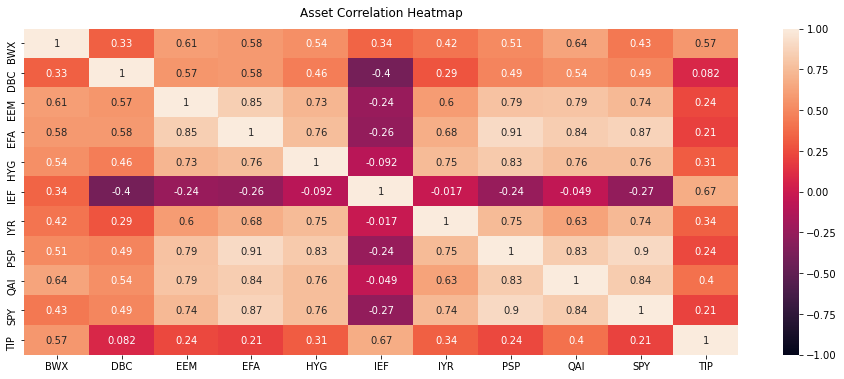

In [33]:
asset_corr_er = excess_ret.corr()
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(asset_corr_er, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Asset Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [34]:
mean_excess_ret =  np.array(er_performance['Annualized Return'])

tangency_port_er = tangency_portfolio_rfr(mean_excess_ret,excess_ret.cov())

TangencyPort_er_df = pd.DataFrame(tangency_port_er,columns= ["Tangency Portfolio Weight"],index=er_performance.index)
TangencyPort_er_df

target_ret = 0.015
mv_port_er= mv_portfolio_rfr(mean_excess_ret,excess_ret.cov(),target_ret*12,tangency_port_er)

MVPort_er_df = pd.DataFrame(mv_port_er,columns= ["Mean-Variance Portfolio Weight"],index=er_performance.index)
mv_portfolios = pd.concat([MVPort_er_df.T,TangencyPort_er_df.T]).T
mv_portfolios = mv_portfolios.merge(descriptions, left_index = True, right_index = True)
mv_portfolios

,Mean-Variance Portfolio Weight,Tangency Portfolio Weight,shortName
BWX,-0.680999,-2.521104,SPDR Bloomberg International Tr
DBC,0.126518,0.468378,Invesco DB Commodity Index Trac
EEM,0.201106,0.744506,iShares MSCI Emerging Index Fun
EFA,-0.072208,-0.267319,iShares MSCI EAFE ETF
HYG,0.542378,2.007920,iShares iBoxx $ High Yield Corp
IEF,1.296374,4.799263,iShares 7-10 Year Treasury Bond
IYR,-0.162310,-0.600881,iShares U.S. Real Estate ETF
PSP,-0.246408,-0.912219,Invesco Global Listed Private E
QAI,-2.383338,-8.823273,IQ Hedge MultiIQ Hedge Multi-St
SPY,1.322159,4.894721,SPDR S&P 500


In [35]:
tangency_port_stats = mvo_performance_stats(mean_excess_ret,excess_ret.cov(),tangency_port_er,'Tangency Portfolio',12)
mv_port_stats = mvo_performance_stats(mean_excess_ret,excess_ret.cov(),mv_port_er,'Mean-Variance Portfolio',12)
pd.concat([mv_port_stats,tangency_port_stats])

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio,0.180000,0.093309,1.92908
Tangency Portfolio,0.666372,0.345435,1.92908


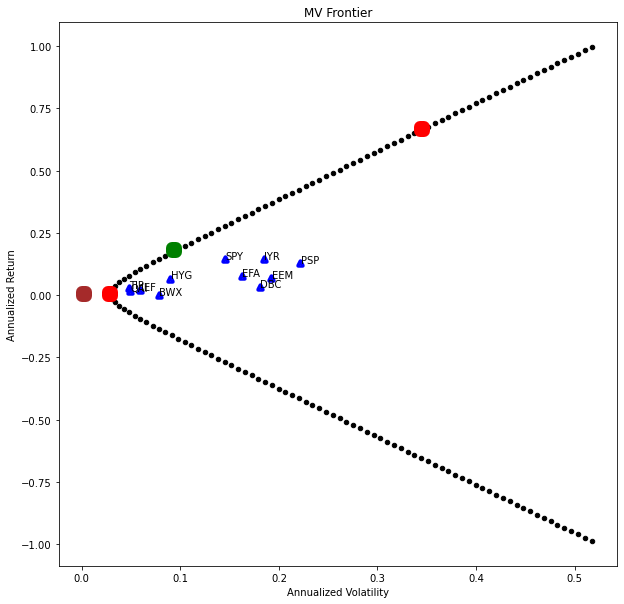

In [36]:
rfr_stats = performance_summary(rfr)

omega_tan= pd.DataFrame(tangency_portfolio_rfr(excess_ret.mean(),excess_ret.cov()), index=excess_ret.columns)
omega_gmv= pd.DataFrame(gmv_portfolio(excess_ret,excess_ret.cov()), index=excess_ret.columns)

omega = pd.concat([omega_tan,omega_gmv],axis=1)
omega.columns = ['tangency','gmv']

delta_grid = np.linspace(-1.5,1.5,150)
mv_frame = pd.DataFrame(columns=['mean','vol'],index=delta_grid)
for i, delta in enumerate(delta_grid):
    omega_mv = delta * omega_tan + (1-delta) * omega_gmv
    rets_p = excess_ret @ omega_mv
    mv_frame['mean'].iloc[i] = rets_p.mean().values[0] * 12
    mv_frame['vol'].iloc[i] = rets_p.std().values[0] * np.sqrt(12)
    
rets_special = pd.DataFrame(index=excess_ret.index)
rets_special['tan'] = excess_ret @ omega_tan.values
rets_special['gmv'] = excess_ret @ omega_gmv.values

mv_assets = pd.concat([excess_ret.mean() * 12,excess_ret.std() * np.sqrt(12)],axis=1)
mv_special = pd.concat([rets_special.mean() * 12, rets_special.std() * np.sqrt(12)],axis=1)
mv_assets.columns = ['mean','vol']
mv_special.columns = ['mean','vol']

ax = mv_frame.plot.scatter(x='vol',y='mean', c='k', figsize=(10,10), title='MV Frontier')
mv_assets.plot.scatter(x='vol',y='mean',ax=ax, c='b', marker='^', linewidth=4)
mv_special.plot.scatter(x='vol',y='mean',ax=ax, c='r', marker='s', linewidth=12)
mv_port_stats.plot.scatter(x = 'Annualized Volatility',y='Annualized Return',ax=ax, c='g', marker='s', linewidth=12)
rfr_stats.plot.scatter(x = 'Annualized Volatility',y='Annualized Return',ax=ax, c='brown', marker='s', linewidth=12)

for i in range(mv_assets.shape[0]):
    plt.text(x=mv_assets['vol'][i]+.0005, y=mv_assets['mean'][i]+.0005, s=mv_assets.index[i])

## 2. Long-short positions.

### 2.a) Consider an allocation between only Domestic Bonds (IEF) and Inflation-Protected Bonds (TIP). Drop all other return columns and recompute wp for $\mu^{p}$ = .0135.

In [37]:
fi_excess_ret = excess_ret.loc[:,['IEF','TIP']]
fi_performance = performance_summary(fi_excess_ret)

mean_fi_er =  np.array(fi_performance['Annualized Return'])

tangency_port_fi_er = tangency_portfolio_rfr(mean_fi_er,fi_excess_ret.cov())

TangencyPort_fi_er_df = pd.DataFrame(tangency_port_fi_er,columns= ["Tangency Portfolio Weight"],index=fi_performance.index)

target_ret = 0.0135
mv_port_fi_er= mv_portfolio_rfr(mean_fi_er,fi_excess_ret.cov(),target_ret*12,tangency_port_fi_er)

MVPort_fi_er_df = pd.DataFrame(mv_port_fi_er,columns= ["Mean-Variance Portfolio Weight"],index=fi_performance.index)
fi_mv_portfolios = pd.concat([MVPort_fi_er_df.T,TangencyPort_fi_er_df.T]).T
fi_mv_portfolios = fi_mv_portfolios.merge(descriptions, left_index = True, right_index = True)
fi_mv_portfolios

,Mean-Variance Portfolio Weight,Tangency Portfolio Weight,shortName
IEF,-0.861631,-0.169482,iShares 7-10 Year Treasury Bond
TIP,5.945552,1.169482,iShares TIPS Bond ETF


In [38]:
tangency_fi_er_stats = mvo_performance_stats(mean_fi_er,fi_excess_ret.cov(),tangency_port_fi_er,'Tangency Portfolio',12)
mv_fi_er_stats = mvo_performance_stats(mean_fi_er,fi_excess_ret.cov(),mv_port_fi_er,'Mean-Variance Portfolio',12)
pd.concat([mv_fi_er_stats,tangency_fi_er_stats])

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio,0.162000,0.251896,0.643123
Tangency Portfolio,0.031865,0.049548,0.643123


### 2.b) What is causing the extreme long-short position?

- Highly Correlated assets 
- Ability to borrow/lend at the risk free rate

### 2.c) Make an adjustment to $\tilde{\mu}^{TIP}$ of -0.0015 (note the negative sign.) Recompute $w^{p}$ for  $\tilde{\mu}^{p}$ = 0.135 for these two assets.
### How does the allocation among the two assets change?

In [39]:
fi_excess_ret = excess_ret.loc[:,['IEF','TIP']]
fi_performance = performance_summary(fi_excess_ret)
fi_performance.loc['TIP',['Annualized Return']] = fi_performance.loc['TIP',['Annualized Return']] - (0.0015*12)

mean_fi_er =  np.array(fi_performance['Annualized Return'])

tangency_port_fi_er = tangency_portfolio_rfr(mean_fi_er,fi_excess_ret.cov())

TangencyPort_fi_er_df = pd.DataFrame(tangency_port_fi_er,columns= ["Tangency Portfolio Weight"],index=fi_performance.index)

target_ret = 0.0135
mv_port_fi_er= mv_portfolio_rfr(mean_fi_er,fi_excess_ret.cov(),target_ret*12,tangency_port_fi_er)

MVPort_fi_er_df = pd.DataFrame(mv_port_fi_er,columns= ["Mean-Variance Portfolio Weight"],index=fi_performance.index)
fi_mv_portfolios = pd.concat([MVPort_fi_er_df.T,TangencyPort_fi_er_df.T]).T
fi_mv_portfolios = fi_mv_portfolios.merge(descriptions, left_index = True, right_index = True)
fi_mv_portfolios

,Mean-Variance Portfolio Weight,Tangency Portfolio Weight,shortName
IEF,7.134322,0.889849,iShares 7-10 Year Treasury Bond
TIP,0.883130,0.110151,iShares TIPS Bond ETF


In [40]:
tangency_fi_er_stats = mvo_performance_stats(mean_fi_er,fi_excess_ret.cov(),tangency_port_fi_er,'Tangency Portfolio',12)
mv_fi_er_stats = mvo_performance_stats(mean_fi_er,fi_excess_ret.cov(),mv_port_fi_er,'Mean-Variance Portfolio',12)
pd.concat([mv_fi_er_stats,tangency_fi_er_stats])

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Portfolio,0.162000,0.453108,0.35753
Tangency Portfolio,0.020206,0.056515,0.35753


### 2.d) What does this suggest about the statistical precision of the MV solutions?

## 3. Robustness

### 3.a) In building $w^{tan}$, do not use $\Sigma$ as given in the formulas in the lecture. Rather, use a diagonalized $\Sigma^{D}$, which zeroes out all non-diagonal elements of the full covariance matrix, $\Sigma$.
### How does the allocation look now?

In [41]:
mean_excess_ret =  np.array(er_performance['Annualized Return'])

tangency_port_er_diag = tangency_portfolio_rfr(mean_excess_ret,excess_ret.cov(),cov_diagnolize=True)

TangencyPort_er_diag_df = pd.DataFrame(tangency_port_er_diag,columns= ["Tangency Portfolio Weight"],index=er_performance.index)
TangencyPort_er_diag_df

,Tangency Portfolio Weight
BWX,0.000008
DBC,0.019131
EEM,0.033643
EFA,0.053013
HYG,0.151905
IEF,0.109670
IYR,0.077830
PSP,0.047752
QAI,0.137519
SPY,0.126036


### 3.b) What does this suggest about the sensitivity of the solution to estimated means and estimated covariances?

The mean variance solution when we have a full covariance matrix  is very sensitive to means and covariances. If two securities are quite correlated, the MV solution will take a long position in the security with the higher mean, and a short position in the security with the lower mean. This can result in much more variation in the magnitude of portfolio weights. As can be seen above, with the diagonalized  the weights are within a much tighter range.

### 3.c) HMC deals with this sensitivity by using explicit constraints on the allocation vector. Conceptually, what are the pros/cons of doing that versus modifying the formula with $\Sigma^{D}$?

<b>Pros</b>:

- Covariances are actually being taken into account when we diversify, which should lead to a better Sharpe.
- While covariance and correlation can change, correlation between assets is quite sticky.<br><br>

<b>Cons</b>:

- Setting constraints may not be optimal as these constraints are arbitrary parameters.
- With many securities, this problem becomes computationally difficult.
- Covariance and security performance changes, we still have the risk of taking positions based on in sample data that could lead to poor OOS results.

### 3.d) How does this diagonalized covariance approach compare to the risk-parity approach?

In [60]:
mv_port_er_diag= mv_portfolio_rfr(mean_excess_ret,excess_ret.cov(),target_ret*12,tangency_port_er_diag)
mv_stats_er_diag = mvo_performance_stats(mean_excess_ret,np.diag(np.diag(excess_ret.cov())),mv_port_er_diag,'Mean-Variance Diagnolized',12)

risk_par_wt_er = np.array(1/er_performance['Annualized Volatility'])
rp_rescale_factor = target_ret*12/ (risk_par_wt.T @ mean_excess_ret)

risk_parity_stats_er = mvo_performance_stats(mean_excess_ret,excess_ret.cov(),(risk_par_wt * rp_rescale_factor),'Risk Parity Portfolio',12)
pd.concat([mv_stats_er_diag,risk_parity_stats])



,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio
Mean-Variance Diagnolized,0.015849,0.008388,1.889535
Risk Parity Portfolio,0.180000,0.235607,0.763983


## 4 Iterate the Out-of-Sample performance every year, not just the final year. Namely

- ### Start at the end of 2014, and calculate the MV weights through that time. Apply them to the returns in the upcoming year, (2015.)

- ### Step forward a year in time, and recompute.
- ### Continue until again calculating the MV weights through 2021 and applying them to the returns in 2022.

### Report the mean, volatility, and Sharpe from this dynamic MV approach. 

### Compare them to the dynamic versions of...
- the equally-weighted portfolio
- the "risk-parity" portfolio
- the diagonalized MV portfolio.

In [55]:
def run_dynamic_portfolios(asset_returns, target_return = 0.0135,start_year = 2014, end_year = 2021, strat = 'Mean-Variance'):

    curr_year = start_year

    df = pd.DataFrame(data = None, columns = [strat + ' Mean',strat + ' Vol',strat + ' Sharpe'])

    while curr_year <= end_year:
        OOS_year = curr_year + 1

        return_data = asset_returns.loc[:str(curr_year)]
        oos_ret_data = asset_returns.loc[str(OOS_year)]
        ret_perf = performance_summary(return_data)
        
        if strat == 'Mean-Variance':
            tangency_port = tangency_portfolio_rfr(np.array(return_data.mean()*12),return_data.cov())
            mv_port= mv_portfolio_rfr(np.array(return_data.mean()*12),return_data.cov(),target_ret*12,tangency_port)
            performance_stats = mvo_performance_stats(oos_ret_data.mean()*12,oos_ret_data.cov(),mv_port,'Mean-Variance Portfolio',12)

        elif strat == 'Risk-Parity':
            risk_par_wt = np.array(1/ret_perf['Annualized Volatility'])
            rp_rescale_factor = target_ret*12/ (risk_par_wt.T @ ret_perf['Annualized Return'])
            performance_stats = mvo_performance_stats(oos_ret_data.mean()*12,oos_ret_data.cov(),(risk_par_wt * rp_rescale_factor),'Risk Parity Portfolio',12)

        elif strat == 'Equal-Weight':
            EqlWt = np.array(len(ret_perf.index) * [1/len(ret_perf.index)])
            eql_rescale_factor = target_ret*12/(EqlWt.T @ ret_perf['Annualized Return'])
            performance_stats = mvo_performance_stats(oos_ret_data.mean()*12,oos_ret_data.cov(),(EqlWt * eql_rescale_factor),'Equal Weight Portfolio',12)

        elif strat == 'Mean-Variance Diagnolized':
            tangency_port = tangency_portfolio_rfr(np.array(return_data.mean()),return_data.cov(),cov_diagnolize=True)
            mv_port= mv_portfolio_rfr(np.array(return_data.mean()*12),return_data.cov(),target_ret*12,tangency_port)
            performance_stats = mvo_performance_stats(oos_ret_data.mean()*12,oos_ret_data.cov(),mv_port,'Mean-Variance Portfolio',12)
        else:
            raise ValueError('Invalid strategy!')

        df.loc[OOS_year,strat + ' Mean'] = performance_stats['Annualized Return'].values[0]
        df.loc[OOS_year,strat + ' Vol'] = performance_stats['Annualized Volatility'].values[0]
        df.loc[OOS_year,strat + ' Sharpe'] = performance_stats['Annualized Sharpe Ratio'].values[0]
        curr_year += 1
    
    df.index.name = 'OOS Year'
    return df

In [56]:
run_dynamic_portfolios(asset_returns = excess_ret,strat = 'Mean-Variance')

,Mean-Variance Mean,Mean-Variance Vol,Mean-Variance Sharpe
OOS Year,,,
2015,0.070666,0.09427,0.749612
2016,0.132624,0.037571,3.529924
2017,0.092816,0.034872,2.66159
2018,0.030333,0.081545,0.371979
2019,0.225439,0.086044,2.620045
2020,0.258708,0.132364,1.954518
2021,0.122307,0.090149,1.356716
2022,-0.142556,0.204144,-0.698309


In [57]:
run_dynamic_portfolios(asset_returns = excess_ret,strat = 'Mean-Variance Diagnolized')

,Mean-Variance Diagnolized Mean,Mean-Variance Diagnolized Vol,Mean-Variance Diagnolized Sharpe
OOS Year,,,
2015,-0.014854,0.048934,-0.303559
2016,0.051167,0.052778,0.969484
2017,0.083707,0.014713,5.689179
2018,-0.052142,0.053221,-0.979722
2019,0.103268,0.041561,2.484756
2020,0.075484,0.109712,0.688014
2021,0.050518,0.033557,1.505417
2022,-0.133137,0.075989,-1.752058


In [58]:
run_dynamic_portfolios(asset_returns = excess_ret,strat = 'Risk-Parity')

,Risk-Parity Mean,Risk-Parity Vol,Risk-Parity Sharpe
OOS Year,,,
2015,-0.070824,0.092711,-0.763919
2016,0.127804,0.139139,0.918537
2017,0.213205,0.040564,5.255984
2018,-0.140433,0.116325,-1.207238
2019,0.318477,0.142411,2.236317
2020,0.229243,0.331488,0.691556
2021,0.170743,0.118192,1.444629
2022,-0.499569,0.265829,-1.879289


In [59]:
run_dynamic_portfolios(asset_returns = excess_ret,strat = 'Equal-Weight')

,Equal-Weight Mean,Equal-Weight Vol,Equal-Weight Sharpe
OOS Year,,,
2015,-0.072646,0.10355,-0.701555
2016,0.13503,0.141651,0.953262
2017,0.228966,0.037659,6.08002
2018,-0.147857,0.131348,-1.125693
2019,0.321274,0.166903,1.924919
2020,0.181024,0.370346,0.488796
2021,0.23779,0.134436,1.768798
2022,-0.406269,0.236433,-1.718326


<b> Performance of the Mean Variance portfolio is much more consistent, Sharpe is positive every year. <b>